In [1]:
#IMPORTING THE LIBRARIES FOR DATA ANALYISIS AND GRAPH PLOTING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Quick cleanup: remove any leftover globals that could reintroduce leakage. because data is extremely large and very vulnarable to leakage

for v in ['preprocessor','X_train_proc','X_test_proc','X_train_res','y_train_res','y_pred','y_test_final','final_model_booster']:
    if v in globals():
        del globals()[v]
print("cleared possible leaked globals: proceed")


cleared possible leaked globals: proceed


In [3]:
#importing the model and parameters to evaluate the model.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#for imbalanced learning: imblearn helps us to deal with imbalanced datasets.

from imblearn.over_sampling import SMOTE

#xgboost the main model
#i think it's pretty clear by now, i'm married to this model

import xgboost as xgb


#hyperparameterisation 
#for extremely highly sensitive model to detect even the slightest chance of anaemia

import optuna
from optuna.samplers import TPESampler

#shap for model explainablilty: to make the model more understandable to the medical folks

import shap

#for a persistting model: for making the streamlit app
import joblib

#system: so that it does not throw warnings every now and then.

import warnings
warnings.filterwarnings('ignore')

#random state creation for the model reproducibility( we want a unbiased model)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#Visualisation
#wtf is this husl?

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize']= (12,6)
plt.rcParams['font.size']= 10

print('libraries loaded succesfully!')


libraries loaded succesfully!


In [4]:
#dataset loading to the model

df = pd.read_csv('../data/dataset.csv')
print("loaded")
display(df.head())

loaded


,age,gender,hb,rbc,pcv,mcv,mch,mchc,vitamin_b12,folate_level,...,sodium,ejection_fraction,hypertension,diabetes,platelets,smoking,observation_time,anaemia,anaemia_type,death_event
0,32.0,0,10.9,4.26,34.2,80.2,25.5,31.8,0.0,0.0,...,136.625418,38.083612,0,0,263358.029264,0,130.26087,1,NaN,0
1,45.0,0,9.6,3.64,29.9,82.1,26.4,32.2,0.0,0.0,...,136.625418,38.083612,0,0,263358.029264,0,130.26087,1,NaN,0
2,38.0,0,10.1,3.70,32.4,87.6,27.4,31.3,0.0,0.0,...,136.625418,38.083612,0,0,263358.029264,0,130.26087,1,NaN,0
3,37.0,1,11.0,3.93,33.6,85.3,27.9,32.7,0.0,0.0,...,136.625418,38.083612,0,0,263358.029264,0,130.26087,1,NaN,0
4,50.0,0,12.1,4.16,36.5,87.9,29.2,33.2,0.0,0.0,...,136.625418,38.083612,0,0,263358.029264,0,130.26087,0,NaN,0


In [5]:
import os, pandas as pd
backup = os.path.join('..','data','dataset_backup_pre_leakfix.csv')
if os.path.exists(backup):
    df = pd.read_csv(backup)
    print('Restored backup, df.shape =', df.shape)
    print('columns:', df.columns.tolist())
else:
    raise FileNotFoundError(f'No backup at {backup}')
# then re-run the target-detection cell (the one that scans for anaemia_type etc.)

Restored backup, df.shape = (2271, 30)
columns: ['age', 'gender', 'hb', 'rbc', 'pcv', 'mcv', 'mch', 'mchc', 'vitamin_b12', 'folate_level', 'iron_level', 'ferritin_level', 'fatigue', 'pallor', 'dizziness', 'shortness_of_breath', 'palpitations', 'glossitis', 'brittle_nails', 'jaundice', 'cpk', 'creatinine', 'sodium', 'ejection_fraction', 'hypertension', 'diabetes', 'platelets', 'smoking', 'observation_time', 'death_event']


In [6]:
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

target_col = 'death_event'
if target_col not in df.columns:
    raise KeyError(f"{target_col} not found in df.columns")

# encode if needed and recreate X,y
if df[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])

key_features = [c for c in df.columns if c != target_col]
X = df[key_features].copy()
y = df[target_col].copy()

print('Set target_col =', target_col, ' | X.shape =', X.shape, ' y.shape =', y.shape)
display(df[[target_col]].head())
print('target distribution:\n', y.value_counts())

Set target_col = death_event  | X.shape = (2271, 29)  y.shape = (2271,)


,death_event
0,0
1,0
2,0
3,0
4,0


target distribution:
 death_event
0    2175
1      96
Name: count, dtype: int64


In [7]:
#data cleaning

df.columns = (df.columns
              .str.lower()
              .str.replace(' ', '_')
              .str.replace('-', '_')
              .str.replace('(', '')
              .str.replace(')', '')
              .str.strip())
#standardising removing th column names




In [8]:

from sklearn.preprocessing import LabelEncoder
from IPython.display import display

# If target_col already set and valid, keep it
if 'target_col' in globals() and target_col in df.columns:
    print(f"target_col already set -> {target_col}")
else:
    # include death_event as a likely target plus previous candidates
    candidates = [c for c in ['death_event','anaemia_type','anaemia','diagnosis','target','label'] if c in df.columns]
    if not candidates:
        raise ValueError("target column not found.")
    target_col = candidates[0]
    print(f"Setting target_col = '{target_col}'")

# encode if object
if df[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])
    print("Encoded target_col and stored le_target")

# recreating  X,y
key_features = [c for c in df.columns if c != target_col]
X = df[key_features].copy()
y = df[target_col].copy()
print("Recreated X,y shapes:", X.shape, y.shape)
display(df[[target_col]].head())


target_col already set -> death_event
Recreated X,y shapes: (2271, 29) (2271,)


,death_event
0,0
1,0
2,0
3,0
4,0


In [9]:

# Reporting missing values and no need to compute them here
#the preprocessing unit will handle the missing values

missing_per_col = df.isnull().sum()
print("Missing values per column (will be handled inside preprocessing pipeline):")
print(missing_per_col[missing_per_col > 0])


Missing values per column (will be handled inside preprocessing pipeline):
Series([], dtype: int64)


In [10]:
#check for missing values.

missing_check = df.isnull().sum().sum()

if missing_check == 0:
    print("ok")
else:
    print("no")
    print(df.isnull().sum()[df.isnull().sum()>0])

ok


In [11]:

# Build X (features) and y (target) — ensuring target excluded from features

key_features = [c for c in df.columns if c != target_col]

X = df[key_features].copy()    #key features copied.

y = df[target_col].copy()

print(f"using {len(key_features)} features (target excluded)")    #tells the total number of features going to be used

display(X.head())


using 29 features (target excluded)


,age,gender,hb,rbc,pcv,mcv,mch,mchc,vitamin_b12,folate_level,...,jaundice,cpk,creatinine,sodium,ejection_fraction,hypertension,diabetes,platelets,smoking,observation_time
0,32.0,0,10.9,4.26,34.2,80.2,25.5,31.8,0.0,0.0,...,0,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087
1,45.0,0,9.6,3.64,29.9,82.1,26.4,32.2,0.0,0.0,...,0,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087
2,38.0,0,10.1,3.70,32.4,87.6,27.4,31.3,0.0,0.0,...,0,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087
3,37.0,1,11.0,3.93,33.6,85.3,27.9,32.7,0.0,0.0,...,0,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087
4,50.0,0,12.1,4.16,36.5,87.9,29.2,33.2,0.0,0.0,...,0,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087


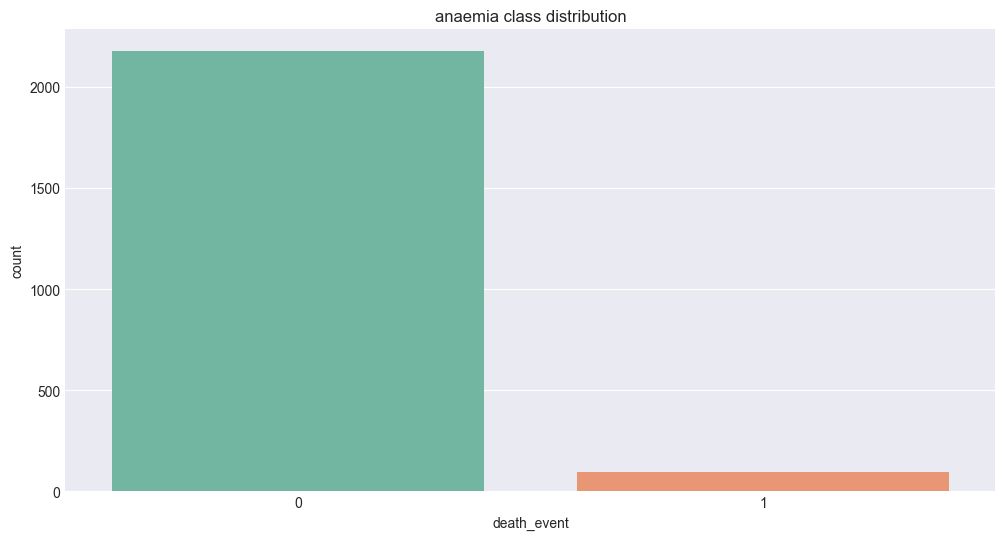

death_event
0    2175
1      96
Name: count, dtype: int64


In [12]:
#target distribution
sns.countplot(x=y, palette='Set2')
plt.title("anaemia class distribution")
plt.show()
print(pd.Series(y).value_counts())
#shows that how many people died of anaemia and how many survived.
#here death is the target column

In [13]:

# Removed early scaling to avoid data leakage. Preprocessing happens in the dedicated cell.
#honeslty i dont even remember what was written here.

pass


In [14]:
#check for gpu or cpu, why we are even checking
#i dont even have  gpu

try:
    # sample from X_train_proc (preprocessed training data), not a globally resampled set
    sample_n = min(100, X_train_proc.shape[0])
    test_model = xgb.XGBClassifier(tree_method='gpu_hist', n_estimators=1)
    test_model.fit(X_train_proc[:sample_n], np.asarray(y_train)[:sample_n])
    tree_method = 'gpu_hist'
    print(" GPU detected and usable")

except Exception:
    tree_method = 'hist'
    print(" No GPU or gpu_hist not available, using CPU (hist)")


 No GPU or gpu_hist not available, using CPU (hist)


In [15]:
#for leaking fix

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

print("df columns:", df.columns.tolist())
print("current target_col:", repr(globals().get("target_col", None)))

candidates = [c for c in ['anaemia_type','anaemia','diagnosis','target','label'] if c in df.columns]
print("candidate target cols found in df:", candidates or "none")

if not candidates:
    print("No expected target column present. Restore backup with:")
    print("df = pd.read_csv('../data/dataset_backup_pre_leakfix.csv')  # then re-run this cell")
else:
    if globals().get("target_col") not in df.columns:
        target_col = candidates[0]
        print(f"Setting target_col = '{target_col}'")
    # encode if object
    if df[target_col].dtype == "object":
        le_target = LabelEncoder()
        df[target_col] = le_target.fit_transform(df[target_col])
        print("Encoded target_col and stored le_target")
    # recreate X,y
    key_features = [c for c in df.columns if c != target_col]
    X = df[key_features].copy()
    y = df[target_col].copy()
    print("Recreated X,y shapes:", X.shape, y.shape)
    display(df[[target_col]].head())

df columns: ['age', 'gender', 'hb', 'rbc', 'pcv', 'mcv', 'mch', 'mchc', 'vitamin_b12', 'folate_level', 'iron_level', 'ferritin_level', 'fatigue', 'pallor', 'dizziness', 'shortness_of_breath', 'palpitations', 'glossitis', 'brittle_nails', 'jaundice', 'cpk', 'creatinine', 'sodium', 'ejection_fraction', 'hypertension', 'diabetes', 'platelets', 'smoking', 'observation_time', 'death_event']
current target_col: 'death_event'
candidate target cols found in df: none
No expected target column present. Restore backup with:
df = pd.read_csv('../data/dataset_backup_pre_leakfix.csv')  # then re-run this cell


In [16]:
#one more safety prediction

import os, pandas as pd, difflib
from IPython.display import display

print("files in ../data:", os.listdir('../data'))
print("df shape:", getattr(df, "shape", None))
print("columns:", df.columns.tolist())
display(df.head())

# quick candidate scan (substring + fuzzy)
subs = ['anaem','anaemia','diagnosis','target','label']
candidates = [c for c in df.columns if any(s in c.lower() for s in subs)]
print("substring candidates:", candidates or "none")
print("close matches to 'anaemia_type':", difflib.get_close_matches('anaemia_type', df.columns.tolist(), n=6, cutoff=0.45))



files in ../data: ['dataset.csv', 'dataset_backup_pre_leakfix.csv', 'dataset_no_leak.csv']
df shape: (2271, 30)
columns: ['age', 'gender', 'hb', 'rbc', 'pcv', 'mcv', 'mch', 'mchc', 'vitamin_b12', 'folate_level', 'iron_level', 'ferritin_level', 'fatigue', 'pallor', 'dizziness', 'shortness_of_breath', 'palpitations', 'glossitis', 'brittle_nails', 'jaundice', 'cpk', 'creatinine', 'sodium', 'ejection_fraction', 'hypertension', 'diabetes', 'platelets', 'smoking', 'observation_time', 'death_event']


,age,gender,hb,rbc,pcv,mcv,mch,mchc,vitamin_b12,folate_level,...,cpk,creatinine,sodium,ejection_fraction,hypertension,diabetes,platelets,smoking,observation_time,death_event
0,32.0,0,10.9,4.26,34.2,80.2,25.5,31.8,0.0,0.0,...,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087,0
1,45.0,0,9.6,3.64,29.9,82.1,26.4,32.2,0.0,0.0,...,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087,0
2,38.0,0,10.1,3.70,32.4,87.6,27.4,31.3,0.0,0.0,...,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087,0
3,37.0,1,11.0,3.93,33.6,85.3,27.9,32.7,0.0,0.0,...,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087,0
4,50.0,0,12.1,4.16,36.5,87.9,29.2,33.2,0.0,0.0,...,581.839465,1.39388,136.625418,38.083612,0,0,263358.029264,0,130.26087,0


substring candidates: none
close matches to 'anaemia_type': []


In [17]:

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import joblib
import os
import numpy as np

# ensure training / test splits exist (fallback)
if 'X_train' not in globals() or 'X_test' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# ensure tree_method is defined
try:
    tree_method
except NameError:
    tree_method = 'hist'

# build an unfitted preprocessor to use inside the pipeline (do NOT pre-fit here)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessor_cv = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')

# use original X_train / y_train (not pre-transformed)
X_tune = X_train.copy()
y_tune = y_train.copy()

# choose CV strategy safely based on class counts
min_count = int(y_tune.value_counts().min())
n_classes = int(y_tune.nunique())

if min_count >= 3:
    n_splits = 3
    use_stratify = True
elif min_count >= 2:
    n_splits = 2
    use_stratify = True
else:
    # cannot reliably stratify when a class has <2 samples -> fall back to plain KFold
    n_splits = 3
    use_stratify = False

if use_stratify:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
else:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'tree_method': tree_method,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': 0
    }

    # dynamic objective / num_class depending on number of classes
    n_classes_local = int(y_tune.nunique())
    if n_classes_local <= 1:
        return 0.0  # cannot evaluate with <=1 class
    if n_classes_local == 2:
        params['objective'] = 'binary:logistic'
    else:
        params['objective'] = 'multi:softprob'
        params['num_class'] = n_classes_local

    clf = xgb.XGBClassifier(**params)
    pipeline = ImbPipeline([('preproc', preprocessor_cv),
                            ('smote', SMOTE(random_state=RANDOM_STATE)),
                            ('clf', clf)])
    try:
        scores = cross_val_score(pipeline, X_tune, y_tune, cv=cv, scoring='accuracy', n_jobs=1)
        return float(np.mean(scores))
    except Exception:
        # on fold failures return a low score so Optuna can continue exploring
        return 0.0

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
try:
    study.optimize(objective, n_trials=50)
except Exception as e:
    print("Optuna optimization failed:", e)

best_params = study.best_params.copy() if study.best_params else {}
# ensure deterministic / runtime params present
best_params.update({'tree_method': tree_method, 'random_state': RANDOM_STATE, 'n_jobs': -1, 'verbosity': 0})

# set final objective / num_class based on training labels
n_classes_final = int(y_train.nunique())
if n_classes_final <= 1:
    raise ValueError("Training set has <=1 class; cannot train a classifier.")
if n_classes_final == 2:
    best_params['objective'] = 'binary:logistic'
else:
    best_params['objective'] = 'multi:softprob'
    best_params['num_class'] = n_classes_final

print("Best CV score:", getattr(study, 'best_value', None))
print("Best params:", best_params)

# FINAL train: pipeline with preprocessor + SMOTE + classifier
final_clf = xgb.XGBClassifier(**best_params)
final_pipeline = ImbPipeline([('preproc', preprocessor_cv),
                              ('smote', SMOTE(random_state=RANDOM_STATE)),
                              ('clf', final_clf)])

final_pipeline.fit(X_train, y_train)  # SMOTE applied only during fit on training set
os.makedirs("models", exist_ok=True)
joblib.dump(final_pipeline, "models/final_pipeline.joblib")

# evaluate on held-out test set and expose variables used later
y_pred = final_pipeline.predict(X_test)
y_test_final = y_test  # keep compatibility with downstream cells

print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# expose booster for downstream plotting if available
try:
    final_model_booster = final_pipeline.named_steps['clf'].get_booster()
except Exception:
    final_model_booster = None
# ...existing code...

[I 2025-10-18 18:02:32,080] A new study created in memory with name: no-name-496441b9-3d0e-4fe7-a7b2-58acc324e665
[I 2025-10-18 18:02:34,143] Trial 0 finished with value: 0.9614597823418706 and parameters: {'max_depth': 6, 'learning_rate': 0.2536999076681772, 'n_estimators': 400, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.9614597823418706.
[I 2025-10-18 18:02:34,892] Trial 1 finished with value: 0.9653128949258561 and parameters: {'max_depth': 10, 'learning_rate': 0.010725209743171996, 'n_estimators': 500, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: 0.9653128949258561.
[I 2025-10-18 18:02:35,247] Trial 2 finished with value: 0.95870768895

Best CV score: 0.9757730318486394
Best params: {'max_depth': 7, 'learning_rate': 0.20710937359561066, 'n_estimators': 450, 'subsample': 0.9069032892880005, 'colsample_bytree': 0.7506911285876728, 'gamma': 0.0029956562223052707, 'min_child_weight': 1, 'reg_alpha': 0.038259683041540926, 'reg_lambda': 9.355699414500416, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1, 'verbosity': 0, 'objective': 'binary:logistic'}
Test accuracy: 0.9736263736263736
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       436
           1       0.63      0.89      0.74        19

    accuracy                           0.97       455
   macro avg       0.81      0.94      0.86       455
weighted avg       0.98      0.97      0.98       455



In [18]:
# quick leakage & sanity scan
import json, re
import pandas as pd, numpy as np

print("1) notebook scan for suspicious patterns")
nb = json.load(open(r"c:\Users\64pul\OneDrive\Documents\gp1-anaemia\notebooks\pipeline_for_anaemia.ipynb","r",encoding="utf-8"))
sus=[]
for i,c in enumerate(nb.get("cells",[]),1):
    if c.get("cell_type")!="code": continue
    s="".join(c.get("source",[]))
    if re.search(r"\bpreprocessor\.fit\(", s): sus.append((i,'preprocessor.fit'))
    if re.search(r"\bfit_resample\(", s): sus.append((i,'fit_resample'))
    if re.search(r"\bfillna\(", s): sus.append((i,'fillna'))
print("suspicious cells:", sus or "none")

print("\n2) duplicate rows between X_train and X_test")
try:
    common = pd.merge(X_test.reset_index(drop=True), X_train.reset_index(drop=True), how='inner')
    print("duplicate rows count:", len(common))
except Exception as e:
    print("could not check duplicates:", e)

print("\n3) numeric features highly correlated with target (|corr|>0.9)")
try:
    num = X_train.select_dtypes(include=[np.number]).columns.tolist()
    corrs = X_train[num].corrwith(pd.Series(y_train).astype(float))
    print(corrs[corrs.abs()>0.9])
except Exception as e:
    print("numeric check failed:", e)

print("\n4) categorical features that map to a single target value per category value")
try:
    joined = X_train.join(pd.Series(y_train, name="_target"))
    cats = joined.select_dtypes(include=['object','category']).columns.tolist()
    for c in cats:
        mapping = joined.groupby(c)["_target"].nunique()
        if (mapping==1).any():
            print(f"{c} has value->single-target mapping (possible leakage)")
except Exception as e:
    print("categorical check failed:", e)

print("\n5) top feature importances from trained model (booster)")
try:
    booster = final_pipeline.named_steps['clf'].get_booster()
    fi = booster.get_score(importance_type='gain')
    top = sorted(fi.items(), key=lambda x: -x[1])[:20]
    print("top features (booster feature id -> gain):", top)
except Exception as e:
    print("feature importance check failed:", e)

1) notebook scan for suspicious patterns
suspicious cells: none

2) duplicate rows between X_train and X_test
duplicate rows count: 0

3) numeric features highly correlated with target (|corr|>0.9)
Series([], dtype: float64)

4) categorical features that map to a single target value per category value

5) top feature importances from trained model (booster)
top features (booster feature id -> gain): [('f28', 10.66418743133545), ('f20', 8.90165901184082), ('f23', 2.1794025897979736), ('f21', 1.4912323951721191), ('f6', 0.8811370134353638), ('f22', 0.8013569116592407), ('f1', 0.6999546885490417), ('f26', 0.6820263266563416), ('f27', 0.4444579482078552), ('f24', 0.43647515773773193), ('f25', 0.3269709050655365), ('f0', 0.314872682094574)]


In [19]:
# ...existing code...
# improved duplicate inspector: show sample rows and match counts
Xt = X_test.reset_index().rename(columns={'index':'test_idx'})
Xr = X_train.reset_index().rename(columns={'index':'train_idx'})
Xt['_target_test'] = y_test.reset_index(drop=True).values
Xr['_target_train'] = y_train.reset_index(drop=True).values
common = Xt.merge(Xr, on=list(X.columns), how='inner', suffixes=('_test','_train'))
print("duplicate pairs found:", len(common))
if len(common):
    display(common[['test_idx','train_idx','_target_test','_target_train']].head(50))
    same_labels = (common['_target_test'] == common['_target_train']).sum()
    print(f"of {len(common)} duplicates, {same_labels} have same label, {len(common)-same_labels} have different labels")
    mism = common[common['_target_test'] != common['_target_train']].head(10)
    if len(mism):
        print("examples with differing labels (first 10):")
        display(mism)
# ...existing code...

duplicate pairs found: 0


In [20]:
# detailed duplicate inspector: counts, examples and original df indices
Xt = X_test.reset_index().rename(columns={'index':'test_idx'})
Xr = X_train.reset_index().rename(columns={'index':'train_idx'})
Xt['_target_test'] = y_test.reset_index(drop=True).values
Xr['_target_train'] = y_train.reset_index(drop=True).values
common = Xt.merge(Xr, on=list(X.columns), how='inner', suffixes=('_test','_train'))

print("duplicate pairs found:", len(common))
if len(common):
    same_labels = (common['_target_test'] == common['_target_train']).sum()
    diff_labels = len(common) - same_labels
    print(f"  same label pairs: {same_labels}")
    print(f"  differing label pairs: {diff_labels}\n")
    display(common[['test_idx','train_idx','_target_test','_target_train']].head(50))

    if diff_labels:
        print("Examples with differing labels (first 20):")
        display(common[common['_target_test'] != common['_target_train']].head(20))

    print("\nOriginal df rows involved (first 50 each):")
    print(" test split df indices:", sorted(common['test_idx'].unique())[:50])
    print(" train split df indices:", sorted(common['train_idx'].unique())[:50])

    # show the original df rows for quick manual inspection
    display(df.loc[sorted(common['test_idx'].unique())].head(20))
    display(df.loc[sorted(common['train_idx'].unique())].head(20))

duplicate pairs found: 0


In [21]:
# ...existing code...
before = len(df)
df = df.drop_duplicates()
print("removed duplicates:", before - len(df), "remaining rows:", len(df))

# recreate X,y and re-split
from sklearn.preprocessing import LabelEncoder
if df[target_col].dtype == 'object':
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])

key_features = [c for c in df.columns if c != target_col]
X = df[key_features].copy()
y = df[target_col].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("new split sizes:", X_train.shape, X_test.shape)
# ...existing code...

removed duplicates: 0 remaining rows: 2271
new split sizes: (1816, 29) (455, 29)


In [24]:
# quick runtime checks
import numpy as np
print("target in X columns:", target_col in X.columns)
print("Any global X_train_res present (should be False):", 'X_train_res' in globals())
print("Any global y_train_res present (should be False):", 'y_train_res' in globals())
print("preprocessor fitted:", 'preprocessor' in globals() and hasattr(preprocessor, 'transform'))
print("X_train_proc exists:", 'X_train_proc' in globals())
print("X_test_proc exists:", 'X_test_proc' in globals())
print("Any remaining NaNs in X_test_proc?:", np.isnan(np.asarray(X_test_proc)).any() if 'X_test_proc' in globals() else "X_test_proc missing")

target in X columns: False
Any global X_train_res present (should be False): False
Any global y_train_res present (should be False): False
preprocessor fitted: False
X_train_proc exists: False
X_test_proc exists: False
Any remaining NaNs in X_test_proc?: X_test_proc missing


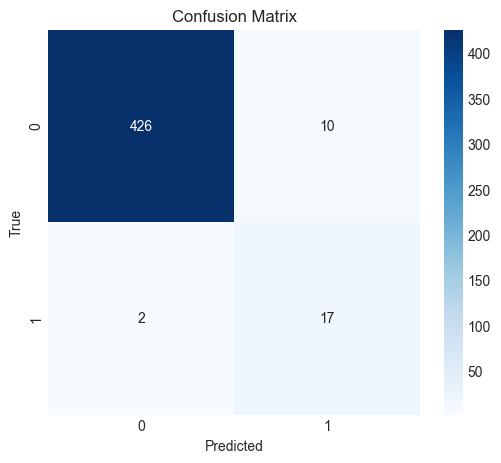

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       436
           1       0.63      0.89      0.74        19

    accuracy                           0.97       455
   macro avg       0.81      0.94      0.86       455
weighted avg       0.98      0.97      0.98       455



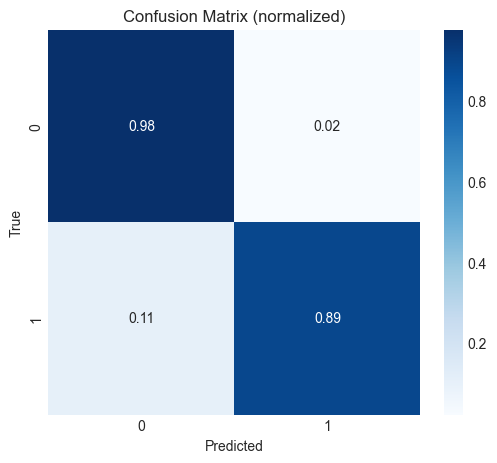

<Figure size 800x600 with 0 Axes>

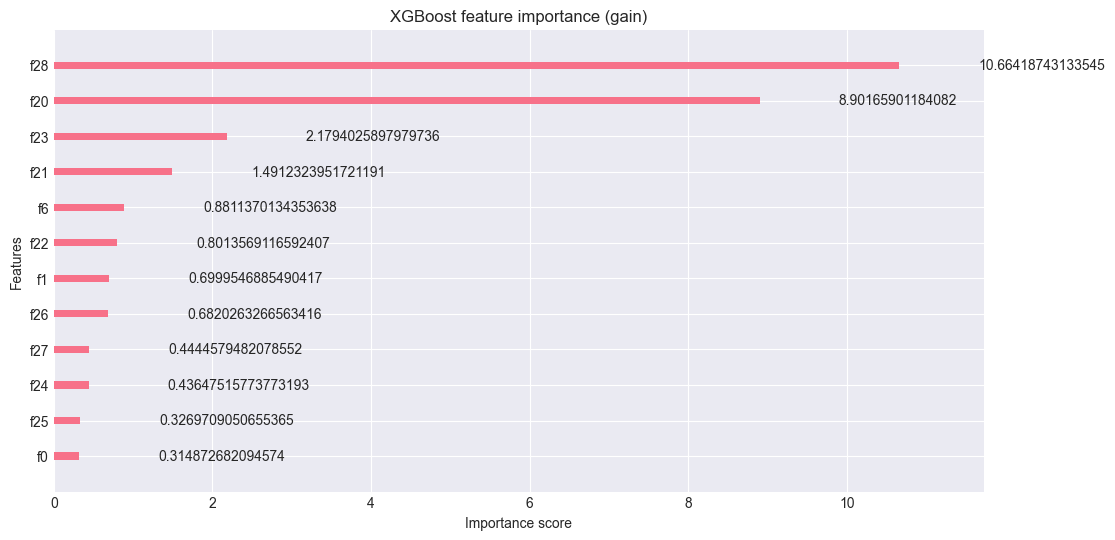

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ensure predictions exist
# y_test_final and y_pred should be available from the evaluation cell
labels = np.unique(np.concatenate([y_test_final, y_pred]))
try:
    # if you encoded target earlier with LabelEncoder named le_target, map back
    class_names = le_target.inverse_transform(labels).astype(str)
except Exception:
    class_names = labels.astype(str)

# raw confusion matrix
cm = confusion_matrix(y_test_final, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# classification report
print(classification_report(y_test_final, y_pred, target_names=class_names))

# normalized confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (normalized)')
plt.show()

# feature importance (if final_model_booster exists)
try:
    import xgboost as xgb
    plt.figure(figsize=(8,6))
    xgb.plot_importance(final_model_booster, max_num_features=20, importance_type='gain')
    plt.title('XGBoost feature importance (gain)')
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)
# ...existing code...